<h1 align="center">AIND-CNC Spring Hackathon</h1>  
<h4 align="center"> May 14, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** This notebook shows how to access and analyze data from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) project established at the Allen Institute for Neural Dynamics. 

**Dataset:** Calcium activity was recorded from hundreds of cortical neurons in the mouse brain while the animal learned and performed a Brain Computer Interface (BCI) task over several days. 
    
**Goal:** This tutorial will show you how to:  
    1. load and work with neuronal calcium activity data processed via suite2p 
    2. plot event-aligned neural activity traces 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [1]:
# general imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import os 
import re
import pandas as pd
from skimage import measure

# pynwb imports to open nwb files
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

from generate_epoch_table import generate_epoch_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

In [2]:
metadata = pd.read_csv('/data/metadata.csv', index_col = False) 

metadata = metadata.sort_values(by = ['name']).reset_index()
metadata[0:10]

# to do - add FOV information 

,index,name,subject_id,session_time,session_type,genotype,virus,session_number
0,9,single-plane-ophys_731015_2025-01-10_18-06-31,731015,2025-01-10T16:46:51.981999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,18.0
1,54,single-plane-ophys_731015_2025-01-13_20-09-20,731015,2025-01-13T18:53:03.001999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,19.0
2,31,single-plane-ophys_731015_2025-01-24_20-00-44,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,20.0
3,36,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,20.0
4,20,single-plane-ophys_731015_2025-01-28_17-40-57,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
5,27,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
6,5,single-plane-ophys_731015_2025-01-28_18-56-35,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
7,10,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,22.0
8,78,single-plane-ophys_731015_2025-01-31_20-37-19,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,23.0
9,90,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,23.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Data Organization 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The metadata "name" column indicates the name of the data asset. 
    
The naming scheme for each data asset is as follows:
 > single-plane-ophys (data type) <br> 
   772414 (subject id number) <br> 
   2025-01-10T16:46:51.981999-08:00 (experiment date (%Y-%m-%d %H:%M:%S)) <br>

In [7]:
# session_name = metadata.name[3]
# session_name

'single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-01-25_12-06-29'

In [11]:
subject_id = metadata.subject_id[3] 
date = metadata.session_time[3][0:10]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load Data 
    
These NWB files are stored in a Zarr format, which is optimized for large data objects stored in the cloud. To load these NWB files, we'll use the NWBZarrIO package from hdmf_zarr.
    
    
We've written a helper function that finds the nwb directory name that matches a given file_name input and loads the data. 

In [9]:
# def load_nwb_by_filename(filename):
#     """
#     Searches the /data directory for the nwb filepath that matches the filename and loads the nwb file. 
    
#     Parameters: 
#     - filename (str): Data file name to match (e.g. 'single-plane-ophys_772414_2025-01-28_16-19-17') 

#     Returns: 
#     - nwbfile: Loaded NWBFile object if found, else None 
#     """ 
    
#     dir_path = [f for f in os.listdir('/data') if re.search(session_name, f)] 
#     if len(dir_path) > 0: # Check if directory match successful 
#         nwb_path = os.path.join('/data', dir_path[0], f'{session_name}_behavior_nwb')
#         if os.path.exists(nwb_path): 
#             try: 
#                 with NWBZarrIO(nwb_path, 'r') as io:
#                     nwbfile = io.read()
#                     print('Loaded NWB file from:', nwb_path)
#                     return nwbfile 
#             except Exception as e: 
#                 print(f'Error loading file from {nwb_path}: {e}')

#         else: 
#             print('NWB file not found at', nwb_path) 
#             return None 
#     else: 
#         print('Directory for', session_name, 'not found') 
#         return None 


In [10]:
# nwbfile = load_nwb_by_filename(session_name)

Directory for single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-01-25_12-06-29 not found


In [15]:
def load_nwb(subject_id, date):
    """
    Searches the /data directory for a folder and subfolder containing the subject_id and date,
    and loads the corresponding NWB file.

    Parameters:
    - subject_id (str): Subject identifier to search for in directory names
    - date (str): Date string (e.g. '2023-05-09') to search for in directory names

    Returns:
    - nwbfile: Loaded NWBFile object if found, else None
    """
    from pathlib import Path
    import re
    
    # Create pattern for matching
    pattern = rf".*{subject_id}.*{date}.*"
    base_path = Path('/data')
    
    # Find matching first-level directories
    first_matches = [d for d in base_path.iterdir() 
                     if d.is_dir() and re.search(pattern, d.name)]
    
    if not first_matches:
        print(f"Directory matching subject_id={subject_id} and date={date} not found in /data.")
        return None
    
    first_dir = first_matches[0]
    print(f"Found first-level directory: {first_dir.name}")
    
    # Find matching second-level directories
    second_matches = [d for d in first_dir.iterdir() 
                      if d.is_dir() and re.search(pattern, d.name)]
    
    if not second_matches:
        print(f"No second-level directory matching subject_id={subject_id} and date={date} found.")
        return None
    
    nwb_path = second_matches[0]
    print(f"Found second-level directory: {nwb_path.name}")
    
    # Check if path exists and load NWB file
    try:
        with NWBZarrIO(str(nwb_path), 'r') as io:
            nwbfile = io.read()
            print('Loaded NWB file from:', nwb_path)
            return nwbfile
    except Exception as e:
        print(f'Error loading file from {nwb_path}: {e}')
        return None

In [16]:
nwbfile = load_nwb(subject_id, date)

Found first-level directory: single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-07_12-19-25
Found second-level directory: single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-07_12-19-25/single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [14]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### 1. Plot Calcium Activity Traces for Select ROIs 
    
The raw data was processed through Suite2p, which extracts the cell body ROIs and calculates the change in fluorescence (dff). Let's pull that data from the nwb file below. The shape of dff is (frames, roi). 
    
We'll also save the frame_rate so we can easily convert from frames to seconds. 
    

In [62]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape:',np.shape(dff))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape: (232140, 385)
Frame Rate: 58.2634


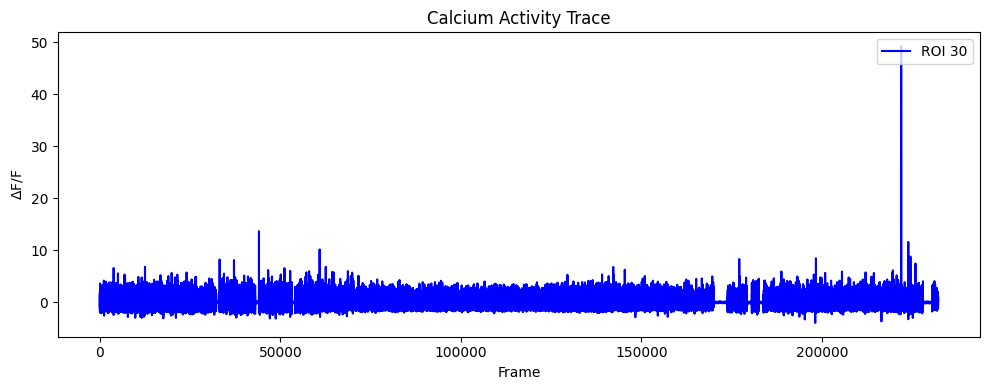

In [63]:
# Select an ROI 
ROI = 30

# Create figure with two vertically stacked plots 

# Top: Calcium trace plot
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='blue')

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons * 
    2. Spontaneous activity *
    3. BCI behavior task 
    4. Spontaneous activity * 
    5. Photostimulation of single neurons * 
    

The stimulus tables in the stimulus>PhotostimTrials and the behavior table in the intervals>trials containers contains the start/stop times for each epoch. 

*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The PhotostimTrials table contains relevant information about the 2p optogenetic stimulus. 


| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stim_name    | stimulus name   |
| laser_stim_x    | x coordinate of stimulated neuron (pixel)   |
| laser_stim_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)*    |

*note that this number does not correspond to the image segmentation ROI index

In [64]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim


,start_time,stop_time,start_frame,stop_frame,tiff_file,stim_name,laser_stim_x,laser_stim_y,power,duration,stimulus_function,group_index
id,,,,,,,,,,,,
0,0.000000,1.132787,0,66,spont_slm_00001.tif,photostim,165.567568,196.108108,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,21
1,1.149950,2.282737,67,133,spont_slm_00002.tif,photostim,58.403226,197.983871,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,22
2,2.299900,3.415523,134,199,spont_slm_00003.tif,photostim,94.828125,75.828125,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,4
3,3.432687,4.513983,200,263,spont_slm_00004.tif,photostim,358.895833,193.479167,4,1.081296,scanimage.mroi.stimulusfunctions.logspiral,26
4,4.531146,5.629606,264,328,spont_slm_00005.tif,photostim,87.287879,189.833333,4,1.098460,scanimage.mroi.stimulusfunctions.logspiral,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2336,3975.789260,3976.853393,231643,231705,spontpost_slm_01290.tif,photostim_post,340.250000,98.444444,4,1.064133,scanimage.mroi.stimulusfunctions.logspiral,35
2337,3976.870557,3977.951853,231706,231769,spontpost_slm_01291.tif,photostim_post,253.025641,218.179487,4,1.081296,scanimage.mroi.stimulusfunctions.logspiral,32
2338,3977.969017,3979.084640,231770,231835,spontpost_slm_01292.tif,photostim_post,54.409639,241.734940,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,12


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation periods - one before and one after the BCI behavior sessions. 

In [65]:
photostim.stim_name.unique()

array(['photostim', 'photostim_post'], dtype=object)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The BCI table contains information about the BCI epoch. 

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| BCI_go_cue |  time of go cue relative to start time (s)   |
| BCI_trial_hit   |  boolean of whether trial was hit   |
| BCI_lick_l  | lick times (s)   |
| BCI_reward_time   | reward delivery time (s)   |
| BCI_threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| BCI_zaber_steps   | position of reward port  |
| BCI_movie_name    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |


In [66]:
bci = nwbfile.trials.to_dataframe()
bci


,start_time,stop_time,BCI_go_cue,BCI_trial_hit,BCI_lick_L,BCI_reward_time,BCI_threshold_crossing_times,BCI_zaber_steps,BCI_movie_name,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y
id,,,,,,,,,,,,,
0,1393.379034,1398.699698,0.2359,True,"[1.4923000000000002, 1.6292, 1.7521, 1.8716, 1...",1.4923,1.4402,"[0.5722, 0.7792, 0.9072, 0.9882, 1.0602, 1.138...",neuron53_00001.tif,81183,81493,19.083333,22.083333
1,1398.716862,1404.260651,0.2359,True,"[2.2792, 2.4113, 2.5264, 2.6327000000000003, 2...",2.2792,2.1610,"[1.1298, 1.6857, 1.7597, 1.8227, 1.8717, 1.905...",neuron53_00002.tif,81494,81817,19.083333,22.083333
2,1404.277814,1409.546988,0.2359,True,"[1.6492, 1.7715, 1.8798, 1.9924, 2.1023, 2.216...",1.6492,1.5602,"[1.0237, 1.1028, 1.1527, 1.1997, 1.2397, 1.271...",neuron53_00003.tif,81818,82125,19.083333,22.083333
3,1409.564152,1413.923664,0.2359,True,"[0.0222, 0.9292, 1.0387, 1.1985, 1.3162, 1.437...",1.0387,1.0308,"[0.2863, 0.3373, 0.3833, 0.4243, 0.4653, 0.505...",neuron53_00004.tif,82126,82380,19.083333,22.083333
4,1413.940827,1418.471974,0.2359,True,"[1.1341, 1.2667000000000002, 1.404, 1.5119, 1....",1.2667,1.1805,"[0.3632, 0.6332, 0.7482000000000001, 0.8282, 0...",neuron53_00005.tif,82381,82645,19.083333,22.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2255.893065,2267.976122,0.2359,True,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[0.4557, 1.8936, 2.0876, 2.1936, 2.3206, 3.146...",neuron53_00093.tif,131436,132140,19.083333,22.083333
93,2267.993286,2280.059180,0.2359,True,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[0.4833, 2.2522, 2.4282, 2.7502, 3.0952, 7.542...",neuron53_00094.tif,132141,132844,19.083333,22.083333
94,2280.076343,2287.164841,0.2359,True,"[2.0659, 2.2614, 2.3884000000000003, 2.5129, 2...",2.2614,2.1722,"[0.2863, 0.5643, 0.7813, 0.9493, 1.0412, 1.121...",neuron53_00095.tif,132845,133258,19.083333,22.083333


In [67]:
epoch_table = generate_epoch_table(nwbfile)

epoch_table

,stim_name,start_frame,stop_frame,start_time,stop_time
1,photostim,0,69481,0.000000,1192.532533
3,spont,69482,81182,1192.549697,1393.361870
0,BCI,81183,134768,1393.379034,2313.081626
4,spont_post,134769,147111,2313.098789,2524.929887
2,photostim_post,147112,232139,2524.947051,3984.302324


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now, let's plot the calcium activity trace for a selected ROI, with the different stimulus epochs overlaid. We'll also show the image segmentation for the selected ROI. 

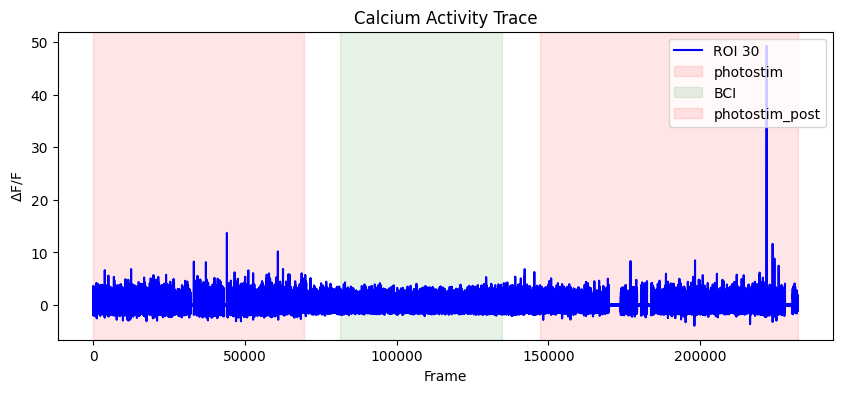

In [68]:
plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='blue')

stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in dff represents an ROI extracted using suite2p then classified as either a soma or a dendrite. 

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

In [69]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,1,0.698194,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.999978,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,0.998079,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,0.994995,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
380,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
381,0,0.392467,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
382,1,0.999609,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

After running suite2p to extract ROIs, an additional classifier is applied to the segmentations to classify somas vs dendrites. Let's filter and save both the dff array and image segmentation to contain only the ROI rows that pass soma detection (is_soma == 1) 

In [80]:
# Filter the image_segmentation table for somas 
soma_segmentation = image_segmentation[image_segmentation.is_soma == 1].reset_index() 

# Filter the dff table for rows that pass soma detection 
soma_dff = dff[:, np.where(image_segmentation.is_soma == 1)[0]]
        

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can combine information from the soma_segmentation table to identify where the ROIs are in the image. Let's add a new plot below our calcium activity trace to show the mask for our selected ROI. 
    
Another piece of data we'll load is the max projection image of the field of view. We'll overlay the ROI masks on top of this image. This is found in the processing container of the NWB. 

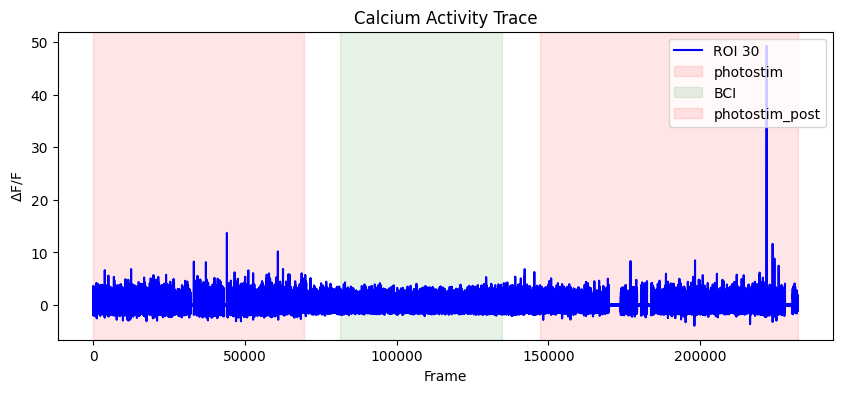

In [82]:
plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='blue')

stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')
plt.show()

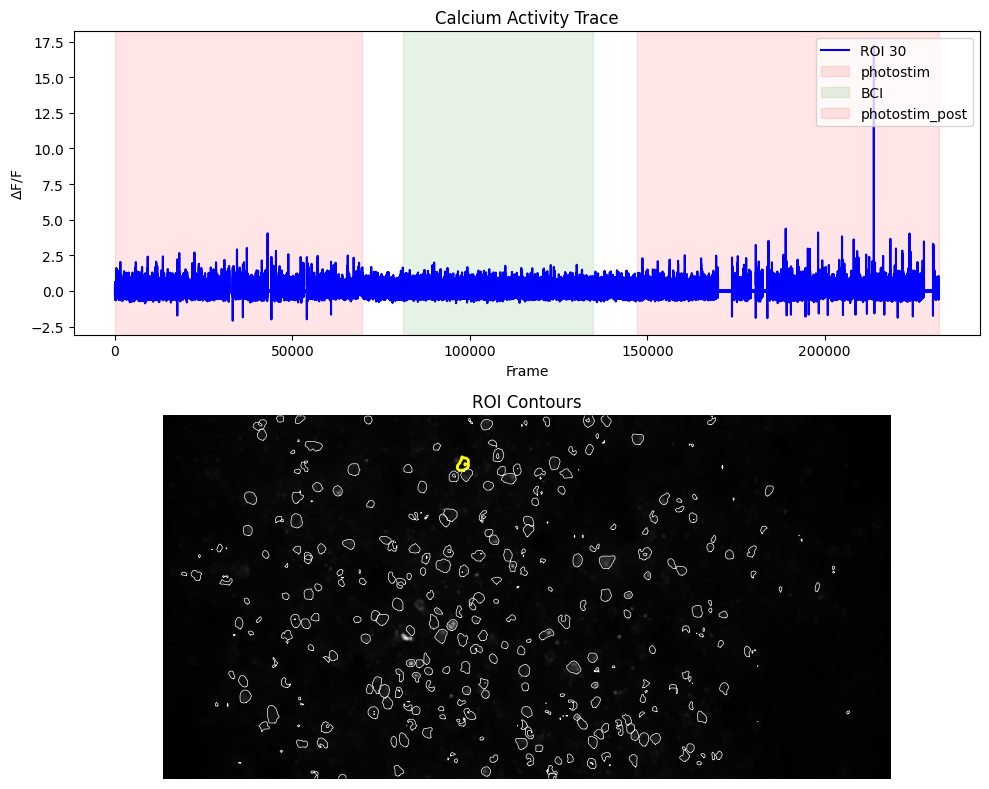

In [83]:
# Parameters 

# Select new ROI 
ROI = 30 

# Image data for FOV 
image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]  # shape: (H, W)

# Create figure with two vertically stacked plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top: Calcium trace plot
ax1.plot(soma_dff[:, ROI], label=f'ROI {ROI}', color='blue')

stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        ax1.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Frame')
ax1.set_title('Calcium Activity Trace')
ax1.legend(loc='upper right')

# Bottom: Grayscale image with ROI contours 
ax2.imshow(image, cmap='gray')
ax2.set_title('ROI Contours')
ax2.axis('off')

# Overlay ROI contours
for i, mask in enumerate(soma_segmentation.image_mask):
    mask_array = np.array(mask)
    contours = measure.find_contours(mask_array, level=0.5)
    for contour in contours:
        color = 'yellow' if i == ROI else 'white'
        linewidth = 2.0 if i == ROI else 0.5
        ax2.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

plt.tight_layout()
plt.show()

In [86]:
def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

Conditioned neuron coordinate: [38.16666667 44.16666667]
Closest ROI is #17 at [42.17948718 20.41025641]


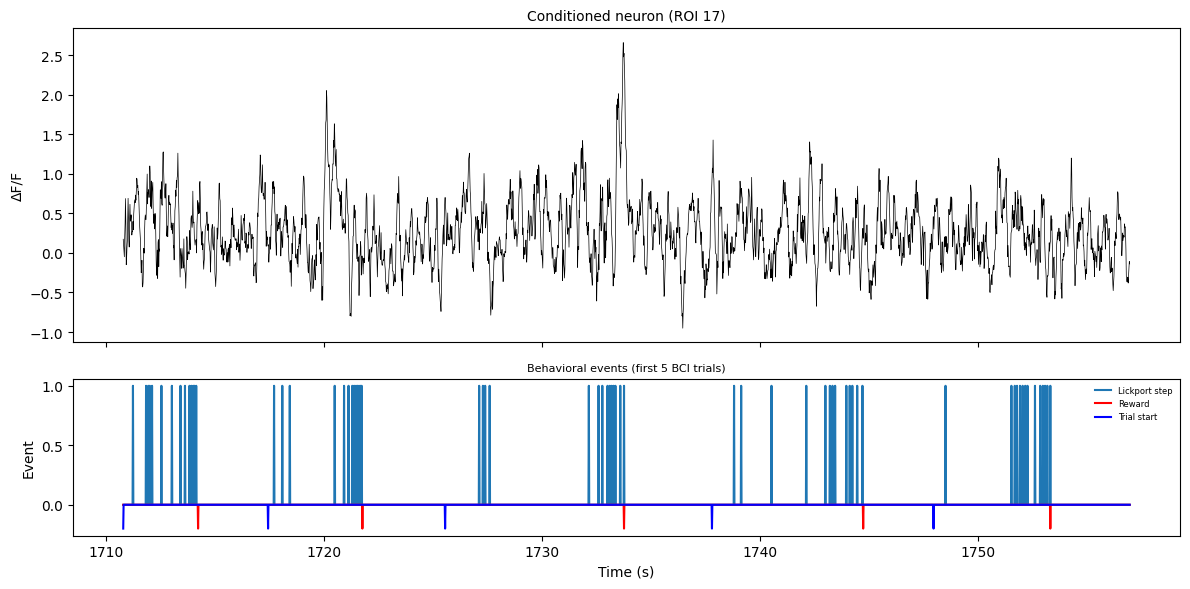

In [93]:
# Set smoothing window size (in frames); set to 0 to disable smoothing
smoothing_window = 10

# Grab the first non-null entry
x = bci['conditioned_neuron_x'].dropna().iloc[0]
y = bci['conditioned_neuron_y'].dropna().iloc[0]
conditioned_coord = np.array([x, y])*2
#conditioned_coord = np.array([164.25, 129.875])
print("Conditioned neuron coordinate:", conditioned_coord)

# Get centroids and match
centroids = get_roi_centroids(soma_segmentation)
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)
conditioned_neuron = np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1))
print(f"Closest ROI is #{conditioned_neuron} at {centroids[conditioned_neuron]}")


# --- Step 2: Build binary time series ---
n_frames = dff.shape[0]
lickport_steps_ts = np.zeros(n_frames)
rewards_ts = np.zeros(n_frames)
trial_starts_ts = np.zeros(n_frames)

for _, row in bci.iterrows():
    try:
        trial_start_f = int(row['BCI_start_frame'])
    except:
        trial_start_f = int(row['start_frame'])

    # Trial start
    if trial_start_f < n_frames:
        trial_starts_ts[trial_start_f] = 1

    # Reward
    rt = row.get('BCI_reward_time', np.nan)
    if not np.isnan(rt):
        reward_f = trial_start_f + int(rt * frame_rate)
        if reward_f < n_frames:
            rewards_ts[reward_f] = 1

    # Zaber steps
    zsteps = row.get('BCI_zaber_steps', [])
    if isinstance(zsteps, (list, np.ndarray)):
        for tstep in zsteps:
            if not np.isnan(tstep):
                step_f = trial_start_f + int(tstep * frame_rate)
                if 0 <= step_f < n_frames:
                    lickport_steps_ts[step_f] = 1

# --- Step 3: Define frame range for first 5 trials ---
try:
    start_f = int(bci['BCI_start_frame'].iloc[0])
    stop_f  = int(bci['BCI_stop_frame'].iloc[4])
except:
    start_f = int(bci['start_frame'].iloc[42])
    stop_f  = int(bci['stop_frame'].iloc[46])
frame_range = slice(start_f, stop_f)
t = np.arange(start_f, stop_f) / frame_rate

# --- Step 4: Plot stacked subplots ---
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, height_ratios=[1, 0.5])

# Top: conditioned neuron
trace = dff[frame_range, conditioned_neuron]

# Apply boxcar smoothing if requested
if smoothing_window > 0:
    kernel = np.ones(smoothing_window) / smoothing_window
    trace = np.convolve(trace, kernel, mode='same')

axs[0].plot(t, trace, 'k', linewidth=0.5)

axs[0].set_ylabel('ΔF/F')
axs[0].set_title(f'Conditioned neuron (ROI {conditioned_neuron})', fontsize=10)

# Bottom: behavioral events
axs[1].plot(t, lickport_steps_ts[frame_range], label='Lickport step')
axs[1].plot(t, -rewards_ts[frame_range]/5, 'r', label='Reward')
axs[1].plot(t, -trial_starts_ts[frame_range]/5, 'b', label='Trial start')
axs[1].legend(fontsize=6, loc='upper right', frameon=False)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Event')
axs[1].set_title('Behavioral events (first 5 BCI trials)', fontsize=8)

plt.tight_layout()
plt.show()
